In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
datasets = ["Auslan", "Autos", "Car", "Cleveland", "Dermatology", "Ecoli", "Flare", "Glass", "Isolet", "Led7digit", "Letter-2", "Lymphography", "Nursery", "Page-blocks", "Penbased", "Satimage", "Segment", "Shuttle", "Vehicle", "Vowel", "Yeast", "Zoo"]
excluded_datasets = ["Ecoli", "Lymphography"]

datasets = [dataset for dataset in datasets if dataset not in excluded_datasets]

results_folder = 'results'
experiment_1 = 'Experiment1'
experiment_2 = 'Experiment2'
experiment_3 = 'Experiment3'
metrics_folder = 'Metrics'

base_classifiers = ['svdd', 'parzen', 'kmeans']
aggregators = ['max_agg', 'decision_templates_agg', 'ecoc_agg']
techniques = ['des', 'desthr']

accuracy = 'accuracy'
kappa = 'kappa'

acc_mean = 'acc_mean'
acc_std = 'acc_std'
kappa_mean = 'kappa_mean'
kappa_std = 'kappa_std'

k_levels = [0, 1, 3]

n_folds = 5

## Figure 8

In [3]:
desthr = techniques[1]

techniques_formatted = {
    'svdd_max_agg_desthr': 'MAX(SVDD)',
    'svdd_decision_templates_agg_desthr': 'DT(SVDD)',
    'svdd_ecoc_agg_desthr': 'ECOC(SVDD)',
    'parzen_max_agg_desthr': 'MAX(PDD)',
    'parzen_decision_templates_agg_desthr': 'DT(PDD)',
    'parzen_ecoc_agg_desthr': 'ECOC(PDD)',
    'kmeans_max_agg_desthr': 'MAX(KMEANS)',
    'kmeans_decision_templates_agg_desthr': 'DT(KMEANS)',
    'kmeans_ecoc_agg_desthr': 'ECOC(KMEANS)'
}

In [4]:
def read_metrics_file(filename):
    return pd.read_csv(filename)

def get_results_filepath(result_folder, experiment, dataset, metrics_folder, metric_name):
    return './{}/{}/{}/{}/{}_{}.csv'.format(result_folder, experiment, dataset, metrics_folder, metric_name, dataset.lower())

In [5]:
def win_tie_loss_parser(value):
    if value > 0:
        return 'W'
    elif value < 0:
        return 'L'
    else:
        return 'T'

In [6]:
def gen_k_win_tie_loss(k, classifiers, aggs, dataset_names):
    global results_folder
    global experiment_1
    global metrics_folder
    global accuracy
    
    k_name = 'k{}'.format(k)

    techniques = []
    for base_classifier in classifiers:
        for aggregator in aggs:
            techniques.append('{}_{}_{}'.format(base_classifier, aggregator, desthr))

    main_df = pd.DataFrame({'Technique': techniques})

    for dataset in dataset_names:
        ex1_filepath = get_results_filepath(results_folder, experiment_1, dataset, metrics_folder, accuracy)
        ex1_results = read_metrics_file(ex1_filepath)
        filtered_ex1 = ex1_results.loc[ex1_results['Technique'].isin(techniques)][['Technique', 'mean']].reset_index(drop=True)

        ex2_filepath = get_results_filepath(results_folder, experiment_2, dataset, metrics_folder, accuracy)
        ex2_results = read_metrics_file(ex2_filepath)
        filtered_ex2 = ex2_results.loc[ex2_results['Technique'] == k_name][['Technique', 'mean']].reset_index(drop=True)

        kwargs = {k_name : lambda x: filtered_ex2.iloc[0]['mean']}
        final_df = filtered_ex1.assign(**kwargs)
        final_df['W/T/L'] = final_df['mean'] - final_df[k_name]
        main_df[dataset] = final_df['W/T/L'].apply(lambda x: win_tie_loss_parser(x))

    main_df['Wins'] = main_df[main_df[dataset_names] == 'W'].count(axis=1)
    main_df['Ties'] = main_df[main_df[dataset_names] == 'T'].count(axis=1)
    main_df['Losses'] = main_df[main_df[dataset_names] == 'L'].count(axis=1)

    return main_df

In [23]:
def knn_win_tie_loss_plot(df, title, xticks=[0, 5, 10, 15, 20], xlim=(0, 20)):
    global techniques_formatted
    global results_folder
    global experiment_2
    
    wtl = df[['Technique', 'Wins', 'Ties', 'Losses']].copy()
    wtl['Technique'] = wtl['Technique'].apply(lambda x: techniques_formatted[x])
    
    wtl.sort_values(by='Technique', inplace=True)
    
    wtl.set_index('Technique', inplace=True)
    
    ax = wtl.plot.barh(stacked=True, color=['green', 'yellow', 'red'], legend=False, title=title, width=1, edgecolor = "black", xticks=xticks, xlim=xlim)
    ax.set_xlabel("no. of datasets")
    ax.set_ylabel("")
    
    fig = ax.get_figure()
    fig.savefig('{}/{}/{}.png'.format(results_folder, experiment_2, title), format='png', dpi=1000, bbox_inches='tight')

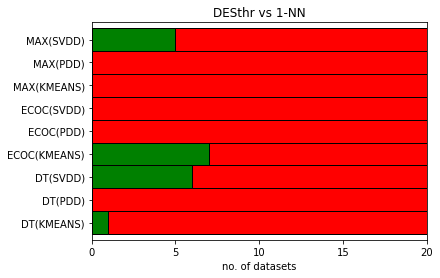

In [24]:
df_k0 = gen_k_win_tie_loss(0, base_classifiers, aggregators, datasets)
knn_win_tie_loss_plot(df_k0, 'DESthr vs 1-NN')

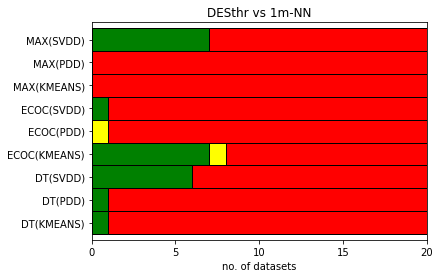

In [25]:
df_k1 = gen_k_win_tie_loss(1, base_classifiers, aggregators, datasets)
knn_win_tie_loss_plot(df_k1, 'DESthr vs 1m-NN')

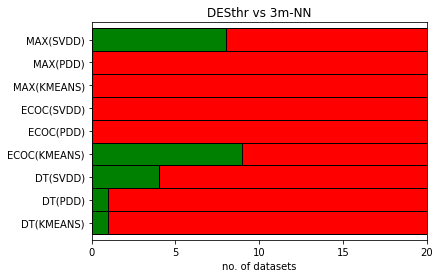

In [26]:
df_k3 = gen_k_win_tie_loss(3, base_classifiers, aggregators, datasets)
knn_win_tie_loss_plot(df_k3, 'DESthr vs 3m-NN')